In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_feynmannd
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import dataset_miscnd
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 150 #50
TRAIN_SIZE  = 1.0/3.0 #0.7
NOISE       = 0.2
MESH_SIZE   = 100
TEST_MESH_SIZE   = 200

POPSIZE          = 500
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 20 #20
GROUP_SIZE       = 3  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3 #5
LIB_MAXLENGTH = 10 #15

BACKPROP_TRIALS = 4

RANDSTATE = 1245

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.RocketFuelFlow()
S = dataset_physics.AircraftLift()
#S = dataset_misc2d.Pagie1()
#S = dataset_miscnd.WavePower()
#S = dataset_feynmannd.FeynmanIICh6Eq15a()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

print(S_train.y.size)
print(S_test.y.size)

50
100


In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      gp_mutator.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
data_evaluator = gp_evaluator.NMSEEvaluator(S_train, linscale=False)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, data_evaluator, know_pressure=0.0)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
corrector.backprop_trials = BACKPROP_TRIALS

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)
profiling.enable()
with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)
profiling.disable()
profiling.print_stats()

  0%|          | 0/19 [00:00<?, ?it/s]

         16945749 function calls (13673563 primitive calls) in 40.809 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   40.809   20.405 interactiveshell.py:3472(run_code)
        1    0.001    0.001   40.788   40.788 gp.py:126(evolve)
       19    0.202    0.011   39.763    2.093 gp.py:169(_create_children)
     9500    0.560    0.000   30.504    0.003 corrector.py:53(correct)
    18780    1.135    0.000   19.471    0.001 corrector.py:151(backprop_know)
1376345/286727    2.524    0.000    8.147    0.000 binop.py:29(__getitem__)
436278/112422    0.369    0.000    7.007    0.000 syntax_tree.py:141(pull_know_deriv)
288558/108996    4.638    0.000    6.755    0.000 binop.py:274(pull_know_deriv)
    19480    0.257    0.000    5.275    0.000 library.py:223(query)
    28877    0.055    0.000    4.915    0.000 library.py:80(query)
    28877    2.878    0.000    4.861    0.000 _kdtree.py:363(query)
    

In [5]:
test_data_evaluator = gp_evaluator.NMSEEvaluator(S_test)
best_stree.clear_output()
print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
print(f"Test NMSE: {test_data_evaluator.evaluate(best_stree).value}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")


--- Best syntax tree ---
((x0 * x1) + (0.82 * ((x2 + x0) * log((x3 * x4)))))
fea: 1.0
NMSE: 0.030214953786311064
Max depth: 5
Length: 14
Test NMSE: 0.0480543662448693


In [ ]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
print(S.evaluate_extra(best_stree))

test_mesh           = space.MeshSpace(S_train, S.knowledge, TEST_MESH_SIZE)
test_know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, test_mesh)
print(test_know_evaluator.evaluate(best_stree))

In [7]:
best_stree.clear_output()
scaler = gp_evaluator.LinearScaler(S_train.y)
best_stree_scaled = scaler.scale_stree(best_stree, best_stree(S_train.X))
best_stree_scaled.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree_scaled, zoomout=1)

best_stree_scaled.clear_output()
print(f"Test NMSE: {test_data_evaluator.evaluate(best_stree_scaled).value}")

Test NMSE: 0.25283922631713723


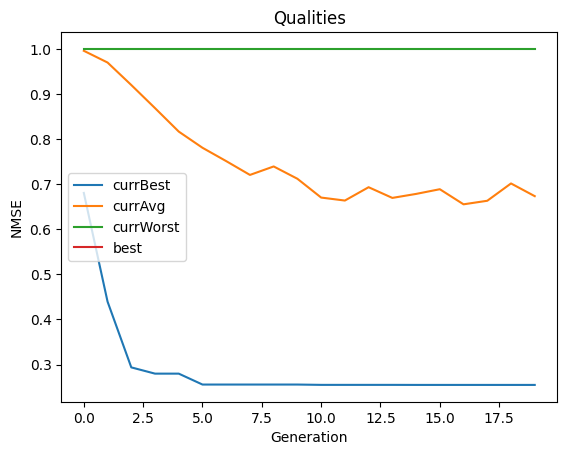

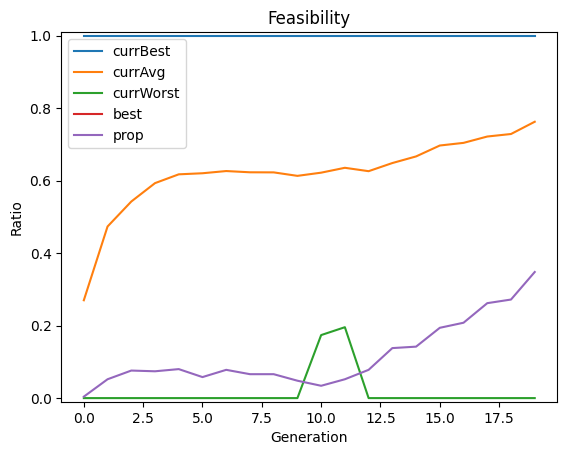

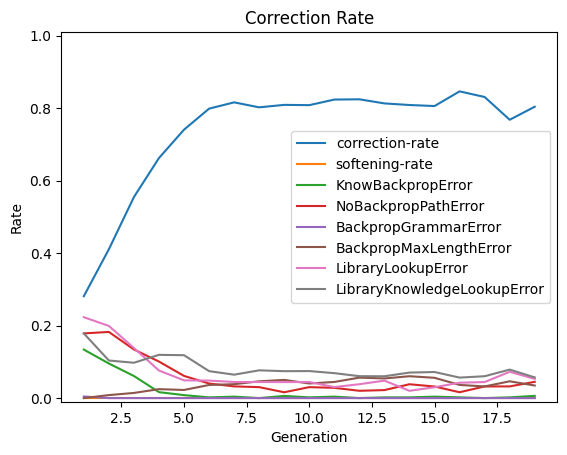

In [8]:
symb_regressor.stats.plot()

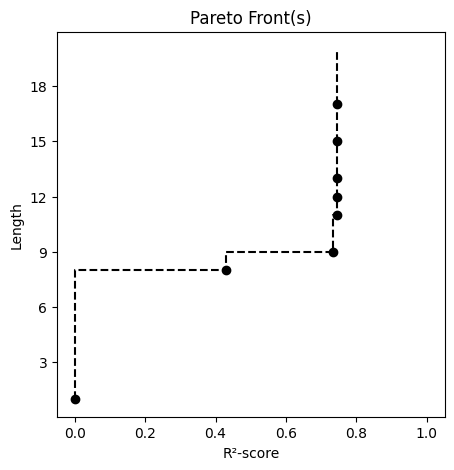

Feasibility Ratio: 1.0
Extent of Convergence: 0.4526462653582296


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,0.00,0,0.000000,0.000000,1,(),1,inf
1,1,((((log((exp(x0) + -0.01)) / -0.12) - x0) + -0...,0,0.111780,0.745197,17,"(exp, log, /, square, +)",2,inf
2,2,(x0 / ((square(x0) + 0.00) / -0.12)),0,0.258470,0.430784,8,"(square, /)",1,1.483203
3,3,((x0 / -0.12) / exp(square((x0 / 0.35)))),0,0.402974,0.732680,9,"(square, exp, /)",1,0.608307
4,4,(((log((exp(x0) + -0.01)) / -0.12) - x0) / exp...,0,0.186271,0.745085,15,"(exp, log, /, square, +)",2,0.250707
5,5,(((x0 / -0.12) - x0) / exp(square((x0 / 0.35)))),0,0.334965,0.744367,11,"(square, exp, +, /)",2,0.203588
6,6,((-5.45 * (x0 + (x0 / 1.39))) / exp(square((x0...,0,0.260635,0.744670,13,"(square, exp, +, /)",2,0.188059
7,7,((log(square(exp(x0))) / -0.21) / exp(square((...,0,0.297867,0.744668,12,"(square, exp, log, /)",1,0.125406


In [9]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, [0])
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)